### Data Preparation - Traffic Calculation

#### Reaading data from Image API

In [85]:
# Data Preparation
# pulling out image URL for the desired time and location

import requests
import pandas as pd
import json

url = "https://api.data.gov.sg/v1/transport/traffic-images?date_time=2021-11-28T12:00:00" # will send an image as per the time 

payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload, verify=False)
data = json.loads(response.text.encode('utf8'))
df_image_url = pd.DataFrame(data['items'][0]['cameras'])
df_image_url = pd.concat([df_image_url.drop(['location', 'image_metadata'], axis=1), df_image_url['location'].apply(pd.Series),df_image_url['image_metadata'].apply(pd.Series)], axis=1)
# df_image_url = df_image_url[(df_image_url['latitude'] == 1.357098686) & (df_image_url['longitude'] == 103.902042) ]
df_image_url


c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,timestamp,image,camera_id,latitude,longitude,height,width,md5
0,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,2703,1.350478,103.791034,288,352,b5fb3395e22ca1564fc5c16ef746e8a9
1,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,2704,1.429589,103.769311,1080,1920,f39663c8c106c657d40fb6433732d832
2,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,1001,1.295313,103.871146,240,320,c4fda9ff078749007add71164968cfc3
3,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,1002,1.319541,103.878563,240,320,d1ecfa5c3f1c3ec9d1aaa5b5d82b7de5
4,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,1003,1.323957,103.872858,240,320,5f713410688f510b43f112c4dcfaec8e
...,...,...,...,...,...,...,...,...
82,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,9702,1.394741,103.817971,1080,1920,857d2ab2c1b22735ed51765ff0b29aad
83,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,9703,1.422857,103.773005,1080,1920,145443758e29f7b2d9e97ece83082122
84,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,9704,1.422143,103.795421,1080,1920,6f662733ba0a7fc87806708c596542d3
85,2021-11-28T11:55:30+08:00,https://images.data.gov.sg/api/traffic-images/...,9705,1.426277,103.787166,1080,1920,97f111760a594a4f21f10992d6d5fa6d


In [87]:
df_image_url.shape[0]

87

##### Extracting image from the url provided

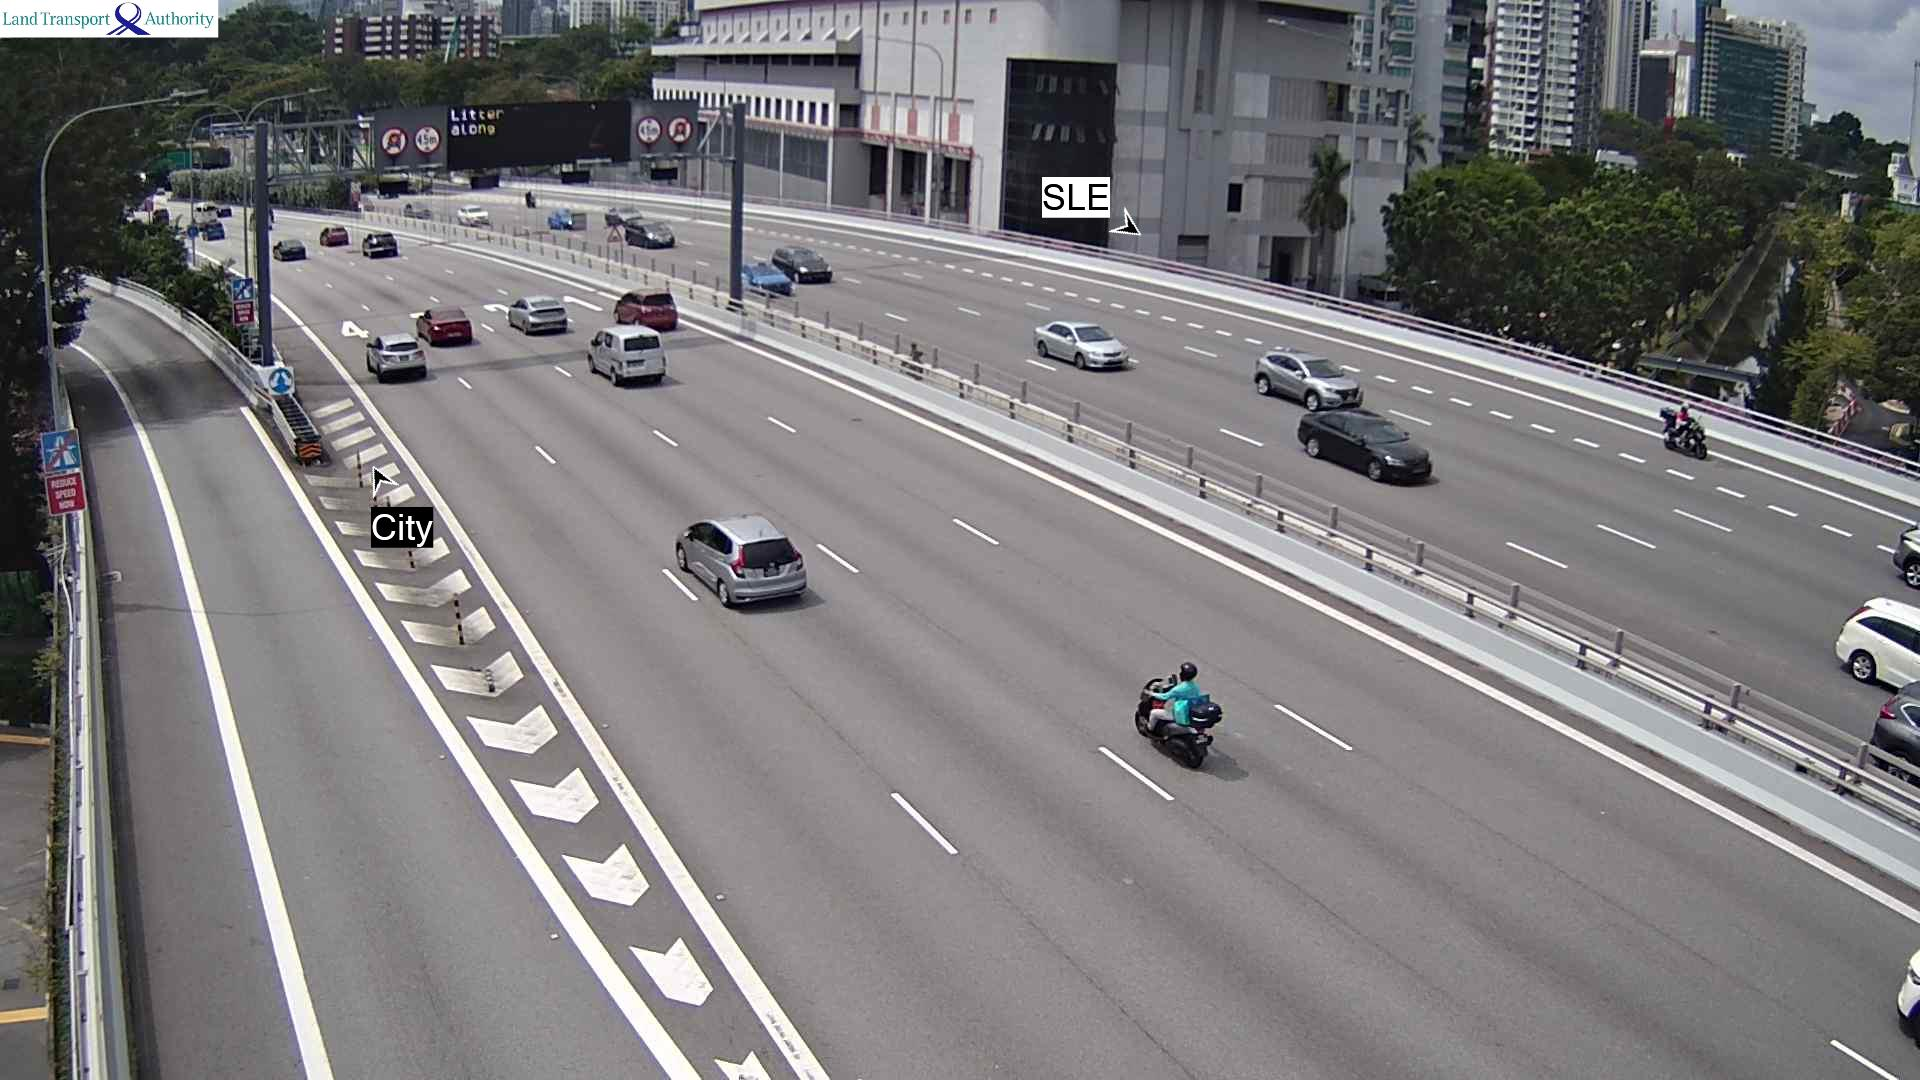

In [124]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(df_image_url['image'].iloc[20])
img = Image.open(BytesIO(response.content))
img

In [125]:
# Converting the pil image to numpy/openCV format
import numpy as np
pil_image = img.convert('RGB') 
open_cv_image = np.array(pil_image) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

##### Detecting and counting the number of cars in the image

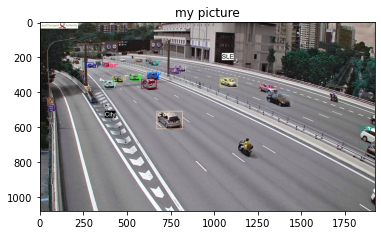

Total number of cars are: 16


In [126]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load Yolo
net = cv2.dnn.readNet(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.weights", r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.cfg")
classes = []
with open(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Resizing image 
img = open_cv_image
# img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape


# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)


# To Show informations on the screen with bounding boxes around objects
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
            
            
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
font = cv2.FONT_HERSHEY_PLAIN

# Plotting rectangles and counting  for cars found in the image
count = 0 # count for number of cars in image
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        if(label == 'car'):
            count = count+1 
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
            
# cv2.imshow("Image", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  

plt.imshow(img)
plt.title('my picture')
plt.show()

print("Total number of cars are: %d"%(count))

#### Data Preparation pipeline for traffic

#### Function for calculating traffic 

In [159]:
import requests
import pandas as pd
import json
from PIL import Image
from io import BytesIO
import numpy as np
import cv2

# Complete function to receive a time stamp string and return the traffic values for all locations
def traffic_data(time):
    
    # need to append time string in the url 
    url = "https://api.data.gov.sg/v1/transport/traffic-images?date_time=%s"%(time) # will send an image as per the time eg. (time = "2021-11-28T12:00:00")

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_image_url = pd.DataFrame(data['items'][0]['cameras'])
    df_image_url = pd.concat([df_image_url.drop(['location', 'image_metadata'], axis=1), df_image_url['location'].apply(pd.Series),df_image_url['image_metadata'].apply(pd.Series)], axis=1)
    
    traffic_count = [] # list to count cars for all images
    
    for i in range(df_image_url.shape[0]): # looping across all images
        response = requests.get(df_image_url['image'].iloc[i])
        img = Image.open(BytesIO(response.content))

        # Converting the pil image to numpy/openCV format
        pil_image = img.convert('RGB') 
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 


        # Load Yolo
        net = cv2.dnn.readNet(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.weights", r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.cfg")
        classes = []
        with open(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        colors = np.random.uniform(0, 255, size=(len(classes), 3))

        # Resizing image 
        img = open_cv_image
        # img = cv2.resize(img, None, fx=0.4, fy=0.4)
        height, width, channels = img.shape


        # Detecting objects
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)


        # To Show informations on the screen with bounding boxes around objects
        class_ids = []
        confidences = []
        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)



        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_PLAIN

        # Plotting rectangles and counting  for cars found in the image
        count = 0 # count for number of cars in image
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                if(label == 'car'):
                    count = count+1 
                    color = colors[i]
                    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                    cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
        
        traffic_count.append(count)

    df_image_url['traffic_count'] = traffic_count
    df_image_url['timestamp'] = time
    
    return df_image_url


In [160]:
# Looping the over a time frame of 1 months once every 3 hours we will extract the past data for model training

from datetime import datetime
from datetime import timedelta

# Given timestamp in string
time_str = '2021-10-01T00:00:00' # Starting date from 28th Oct'21
date_format_str = '%Y-%m-%dT%H:%M:%S'

# create datetime object from timestamp string
time = datetime.strptime(time_str, date_format_str)

n = 3 # counter to increase 3 hours 

data_traffic_train = traffic_data(time.strftime('%Y-%m-%dT%H:%M:%S'))

while(time.month*time.day <=300 ): # looping over a month 308 = 10*30
    
    # Add 3 hours to datetime object
    time = time + timedelta(hours=n)
    
     # Convert datetime object to string in specific format 
    time_str = time.strftime('%Y-%m-%dT%H:%M:%S')
    
    # function call for weather data 
    df_temp = traffic_data(time_str) # function call to get traffic values for the given time
    data_traffic_train = pd.concat([data_traffic_train, df_temp], ignore_index=True)
    


c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

OSError: image file is truncated (7 bytes not processed)

### Deployment Pipeline (ARIMA Forecasting)

In [158]:
# Traffic function with time and location details
import requests
import pandas as pd
import json
from PIL import Image
from io import BytesIO
import numpy as np
import cv2

# Complete function to receive a time stamp string and return the traffic value for specific locations
def traffic(time, lat, long):
    
    # need to append time string in the url 
    url = "https://api.data.gov.sg/v1/transport/traffic-images?date_time=%s"%(time) # will send an image as per the time eg. (time = "2021-11-28T12:00:00")

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_image_url = pd.DataFrame(data['items'][0]['cameras'])
    df_image_url = pd.concat([df_image_url.drop(['location', 'image_metadata'], axis=1), df_image_url['location'].apply(pd.Series),df_image_url['image_metadata'].apply(pd.Series)], axis=1)
    df_image_url = df_image_url[(df_image_url['latitude'] == lat) & (df_image_url['longitude'] == long) ]
    
    traffic_count = [] # list to count cars for all images
    
    for i in range(df_image_url.shape[0]): # looping across all images
        response = requests.get(df_image_url['image'].iloc[i])
        img = Image.open(BytesIO(response.content))

        # Converting the pil image to numpy/openCV format
        pil_image = img.convert('RGB') 
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 


        # Load Yolo
        net = cv2.dnn.readNet(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.weights", r"C:\Users\apurgarg\Documents\CV\siemens\yolo\yolov3.cfg")
        classes = []
        with open(r"C:\Users\apurgarg\Documents\CV\siemens\yolo\coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        colors = np.random.uniform(0, 255, size=(len(classes), 3))

        # Resizing image 
        img = open_cv_image
        # img = cv2.resize(img, None, fx=0.4, fy=0.4)
        height, width, channels = img.shape


        # Detecting objects
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)


        # To Show informations on the screen with bounding boxes around objects
        class_ids = []
        confidences = []
        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)



        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_PLAIN

        # Plotting rectangles and counting  for cars found in the image
        count = 0 # count for number of cars in image
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                if(label == 'car'):
                    count = count+1 
                    color = colors[i]
                    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                    cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
        
        traffic_count.append(count)

    df_image_url['traffic_count'] = traffic_count
    df_image_url['timestamp'] = time
    
    return df_image_url


In [107]:
# Looping the over a time frame of 1 week once every 3 hours we will extract the past data 
# After getting the past data we will run a time series prediction model to forecast the next one
# Collecting the data points on a frequency of 3 hours, hence the next forecast will aslo be for 3 hours away

from datetime import datetime
from datetime import timedelta

# Given timestamp in string
time_str = '2021-10-01T00:00:00' # Would be taken as input from user
date_format_str = '%Y-%m-%dT%H:%M:%S'


# When productionalize, can take these values as inputs

# create datetime object from timestamp string
time = datetime.strptime(time_str, date_format_str)
latitude = 1.357098686 # Would be taken as input 
longitude = 103.902042 # Would be taken as input

n = 3 # counter to increase 3 hours 

data_traffic = traffic(time.strftime('%Y-%m-%dT%H:%M:%S'),latitude,longitude)

for i in range(55): # looping over the past one week data (8*7 = 56)
    
    # Add 3 hours to datetime object
    time = time - timedelta(hours=n)
    
     # Convert datetime object to string in specific format 
    time_str = time.strftime('%Y-%m-%dT%H:%M:%S')
    
    # function call for weather data 
    df_temp = traffic(time_str,latitude,longitude) # function call to get weather values for the given time
    data_traffic = pd.concat([df_temp,data_traffic], ignore_index=True)

data_traffic.head()

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

,timestamp,image,camera_id,latitude,longitude,height,width,md5,traffic_count
0,2021-09-24T03:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,c1300bc9ae1f9df7170451813225b614,0
1,2021-09-24T06:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,6c02d7bfe71c2ef17a848290eecb6359,0
2,2021-09-24T09:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,24fb3296f89a3255757884d951542aa4,8
3,2021-09-24T12:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,93b95164b1d71399593b9ae2c112775e,7
4,2021-09-24T15:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,d4c071b6b4b6165b15021040e598850e,7


In [118]:
# function to forecast based on current traffic series

import pmdarima as pm 

# Using auto arima algorithm to forecast the traffic based on past data estimations
def traffic_prediction(df):
   
    train = df['traffic_count']
    stepwise_fit = pm.auto_arima(train, start_p=1, start_q=1, max_p=7, max_q=7, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',	 # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise= True)  # set to stepwise
    forecast = stepwise_fit.predict(n_periods = 2).tolist()
    return forecast


In [113]:
traffic_forecast = traffic_prediction(data_traffic)
traffic_forecast

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=247.664, BIC=256.470, Time=0.670 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=270.317, BIC=273.839, Time=0.007 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=248.723, BIC=255.768, Time=0.146 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=250.311, BIC=257.356, Time=0.647 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=268.337, BIC=270.098, Time=0.008 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=272.239, BIC=279.284, Time=0.056 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=241.421, BIC=251.989, Time=1.045 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close 

[1.6468769024725007, 2.785235848150238]

In [119]:
# This will print the forecasted values of traffic in the next 3 hour bactches i.e in next 3 hours and in next 6 hours.
print("Traffic in next 3 hour batches:")
for x in traffic_forecast:
    print(round(x,0))

Traffic in next 3 hour batches:
2.0
3.0


### Weather calculation

#### Reading data from Weather APIs

In [61]:
url_air_temp = "https://api.data.gov.sg/v1/environment/air-temperature?date_time=2021-11-28T12:00:00" # will send air temp as per the time 
url_rain = "https://api.data.gov.sg/v1/environment/rainfall?date_time=2021-11-28T12:00:00" # will send rainfall as per the time 
url_rel_hum = "https://api.data.gov.sg/v1/environment/relative-humidity?date_time=2021-11-28T12:00:00" # will send relative humidity as per the time 
url_wind_speed = "https://api.data.gov.sg/v1/environment/wind-speed?date_time=2021-11-28T12:00:00" # will send wind speed as per the time 
url_wind_dir = "https://api.data.gov.sg/v1/environment/wind-direction?date_time=2021-11-28T12:00:00" # will send wind direction as per the time 

payload={}
headers = {}

# Air Temperature
response = requests.request("GET", url_air_temp, headers=headers, data=payload, verify=False)
data = json.loads(response.text.encode('utf8'))
df_air_temp = pd.DataFrame(data['items'][0]['readings'])
df_air_temp.rename(columns={'value': 'air_temp'}, inplace=True)
# preparing a dataframe of location values
df_stations = pd.DataFrame(data['metadata']['stations'])
df_stations = pd.concat([df_stations.drop(['location'], axis=1), df_stations['location'].apply(pd.Series)], axis=1)
df_stations.rename(columns={'device_id': 'station_id'}, inplace=True)
# merging stations data with weather data 
df_weather = pd.merge( df_stations,df_air_temp, how = 'inner',on = 'station_id' )





c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [58]:
# Preparing a dataframe of temperature values
df_air_temp = pd.DataFrame(data['items'][0]['readings'])
df_air_temp.head()

,station_id,value
0,S109,30.4
1,S50,29.8
2,S107,30.8
3,S43,30.3
4,S108,30.2


In [54]:
# preparing a dataframe of location values
df_stations = pd.DataFrame(data['metadata']['stations'])
df_stations = pd.concat([df_stations.drop(['location'], axis=1), df_stations['location'].apply(pd.Series)], axis=1)
# df_stations = df_stations[(df_stations['latitude'] == 1.357098686) & (df_stations['longitude'] == 103.902042) ]
df_stations.rename(columns={'device_id': 'station_id'}, inplace=True)
df_stations

,id,station_id,name,latitude,longitude
0,S109,S109,Ang Mo Kio Avenue 5,1.37640,103.84920
1,S50,S50,Clementi Road,1.33370,103.77680
2,S107,S107,East Coast Parkway,1.31350,103.96250
3,S43,S43,Kim Chuan Road,1.33990,103.88780
4,S108,S108,Marina Gardens Drive,1.27990,103.87030
5,S44,S44,Nanyang Avenue,1.34583,103.68166
6,S121,S121,Old Choa Chu Kang Road,1.37288,103.72244
7,S106,S106,Pulau Ubin,1.41680,103.96730
8,S111,S111,Scotts Road,1.31055,103.83650
9,S115,S115,Tuas South Avenue 3,1.29377,103.61843


In [57]:
# merging stations data with weather data 
df_weather = pd.merge( df_stations,df_air_temp, how = 'inner',on = 'station_id' ).reset_index()
df_weather.rename(columns={'value': 'air_temp'}, inplace=True)
df_weather

,index,id,station_id,name,latitude,longitude,air_temp
0,0,S109,S109,Ang Mo Kio Avenue 5,1.37640,103.84920,30.4
1,1,S50,S50,Clementi Road,1.33370,103.77680,29.8
2,2,S107,S107,East Coast Parkway,1.31350,103.96250,30.8
3,3,S43,S43,Kim Chuan Road,1.33990,103.88780,30.3
4,4,S108,S108,Marina Gardens Drive,1.27990,103.87030,30.2
5,5,S44,S44,Nanyang Avenue,1.34583,103.68166,28.8
6,6,S121,S121,Old Choa Chu Kang Road,1.37288,103.72244,30.0
7,7,S106,S106,Pulau Ubin,1.41680,103.96730,31.1
8,8,S111,S111,Scotts Road,1.31055,103.83650,29.5
9,9,S115,S115,Tuas South Avenue 3,1.29377,103.61843,29.1


#### Training Data Preparation

In [73]:
# Final combination of different weather components to get the final data 

def weather(time):

    url_air_temp = "https://api.data.gov.sg/v1/environment/air-temperature?date_time=%s"%(time) # will send air temp as per the time 
    url_rain = "https://api.data.gov.sg/v1/environment/rainfall?date_time=%s"%(time) # will send rainfall as per the time 
    url_rel_hum = "https://api.data.gov.sg/v1/environment/relative-humidity?date_time=%s"%(time) # will send relative humidity as per the time 
    url_wind_speed = "https://api.data.gov.sg/v1/environment/wind-speed?date_time=%s"%(time) # will send wind speed as per the time 
    url_wind_dir = "https://api.data.gov.sg/v1/environment/wind-direction?date_time=%s"%(time) # will send wind direction as per the time 

    payload={}
    headers = {}

    # Air Temperature
    response = requests.request("GET", url_air_temp, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_air_temp = pd.DataFrame(data['items'][0]['readings'])
    df_air_temp.rename(columns={'value': 'air_temp'}, inplace=True)
    # preparing a dataframe of location values
    df_stations = pd.DataFrame(data['metadata']['stations'])
    df_stations = pd.concat([df_stations.drop(['location'], axis=1), df_stations['location'].apply(pd.Series)], axis=1)
    df_stations.rename(columns={'device_id': 'station_id'}, inplace=True)
    # merging stations data with weather data 
    df_weather = pd.merge( df_stations,df_air_temp, how = 'inner',on = 'station_id' )


    # Rainfall
    response = requests.request("GET", url_rain, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_rain = pd.DataFrame(data['items'][0]['readings'])
    df_rain.rename(columns={'value': 'rainfall'}, inplace=True)
    # merging stations data with weather data 
    df_weather = pd.merge( df_weather,df_rain, how = 'inner',on = 'station_id' )
    # Relative Humidity
    response = requests.request("GET", url_rel_hum, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_rel_hum = pd.DataFrame(data['items'][0]['readings'])
    df_rel_hum.rename(columns={'value': 'rel_hum'}, inplace=True)
    # merging stations data with weather data 
    df_weather = pd.merge( df_weather,df_rel_hum, how = 'inner',on = 'station_id' )


    # Wind Speed
    response = requests.request("GET", url_wind_speed, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_wind_speed = pd.DataFrame(data['items'][0]['readings'])
    df_wind_speed.rename(columns={'value': 'wind_speed'}, inplace=True)
    # merging stations data with weather data 
    df_weather = pd.merge( df_weather,df_wind_speed, how = 'inner',on = 'station_id' )


    # Wind Direction
    response = requests.request("GET", url_wind_dir, headers=headers, data=payload, verify=False)
    data = json.loads(response.text.encode('utf8'))
    df_wind_dir = pd.DataFrame(data['items'][0]['readings'])
    df_wind_dir.rename(columns={'value': 'wind_dir'}, inplace=True)
    # merging stations data with weather data 
    df_weather = pd.merge( df_weather,df_wind_dir, how = 'inner',on = 'station_id' ).reset_index()
    
    df_weather['timestamp'] = time

    return df_weather



In [82]:
# Looping the over a time frame of 1 months once every 3 hours we will extract the past data 

from datetime import datetime
from datetime import timedelta

# Given timestamp in string
time_str = '2021-10-01T00:00:00' # Starting date from 28th Oct'21
date_format_str = '%Y-%m-%dT%H:%M:%S'

# create datetime object from timestamp string
time = datetime.strptime(time_str, date_format_str)

n = 3 # counter to increase 3 hours 

data_weather = weather(time.strftime('%Y-%m-%dT%H:%M:%S'))

while(time.month*time.day <=300 ): # looping over a month 308 = 10*30
    
    # Add 3 hours to datetime object
    time = time + timedelta(hours=n)
    
     # Convert datetime object to string in specific format 
    time_str = time.strftime('%Y-%m-%dT%H:%M:%S')
    
    # function call for weather data 
    df_temp = weather(time_str) # function call to get weather values for the given time
    data_weather = pd.concat([data_weather, df_temp], ignore_index=True)
    


c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

,index,id,station_id,name,latitude,longitude,air_temp,rainfall,rel_hum,wind_speed,wind_dir,timestamp
0,0,S109,S109,Ang Mo Kio Avenue 5,1.37640,103.84920,26.5,0.0,85.6,2.1,226,2021-10-01T00:00:00
1,1,S50,S50,Clementi Road,1.33370,103.77680,26.3,0.0,86.1,3.3,172,2021-10-01T00:00:00
2,2,S107,S107,East Coast Parkway,1.31350,103.96250,28.3,0.0,86.1,9.8,192,2021-10-01T00:00:00
3,3,S43,S43,Kim Chuan Road,1.33990,103.88780,27.0,0.0,88.4,5.0,317,2021-10-01T00:00:00
4,4,S44,S44,Nanyang Avenue,1.34583,103.68166,26.5,0.0,86.6,3.7,191,2021-10-01T00:00:00


In [84]:
# Final weather data collected to be used to train the model.
data_weather.head()

,index,id,station_id,name,latitude,longitude,air_temp,rainfall,rel_hum,wind_speed,wind_dir,timestamp
0,0,S109,S109,Ang Mo Kio Avenue 5,1.37640,103.84920,26.5,0.0,85.6,2.1,226,2021-10-01T00:00:00
1,1,S50,S50,Clementi Road,1.33370,103.77680,26.3,0.0,86.1,3.3,172,2021-10-01T00:00:00
2,2,S107,S107,East Coast Parkway,1.31350,103.96250,28.3,0.0,86.1,9.8,192,2021-10-01T00:00:00
3,3,S43,S43,Kim Chuan Road,1.33990,103.88780,27.0,0.0,88.4,5.0,317,2021-10-01T00:00:00
4,4,S44,S44,Nanyang Avenue,1.34583,103.68166,26.5,0.0,86.6,3.7,191,2021-10-01T00:00:00


### Deployment pipeline 

#### Finding the nearest station from the given latitude and logitude 

In [130]:
# df_stations is the dataframe for all available stations for weather conditions, will to find the given location is closest to which station
df_stations['latitude_user'] = 1.357098686 # These values could be sent through user input
df_stations['longitude_user'] = 103.902042 
df_stations.head()

,id,station_id,name,latitude,longitude,latitude_user,longitude_user
0,S109,S109,Ang Mo Kio Avenue 5,1.3764,103.8492,1.357099,103.902042
1,S50,S50,Clementi Road,1.3337,103.7768,1.357099,103.902042
2,S107,S107,East Coast Parkway,1.3135,103.9625,1.357099,103.902042
3,S43,S43,Kim Chuan Road,1.3399,103.8878,1.357099,103.902042
4,S108,S108,Marina Gardens Drive,1.2799,103.8703,1.357099,103.902042


In [136]:
# To calculate distance between two given latitudes and logitudes. Converting the degrees into distance

from math import sin, cos, sqrt, atan2, radians
def calculate_distance(**kwargs):
    R = 6373.0 # Earth's radius in KM

    lat1 = radians(kwargs['latitude'])
    lon1 = radians(kwargs['longitude'])
    lat2 = radians(kwargs['latitude_user'])
    lon2 = radians(kwargs['longitude_user'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [137]:
# distance between the two points and then finding the closest (distance is calculated in Km)
df_stations['distance'] = [calculate_distance(**df_stations[['latitude', 'longitude', 'latitude_user', 'longitude_user']].iloc[i].to_dict()) for i in range(df_stations.shape[0])]
df_stations.head()

,id,station_id,name,latitude,longitude,latitude_user,longitude_user,distance
0,S109,S109,Ang Mo Kio Avenue 5,1.3764,103.8492,1.357099,103.902042,6.255854
1,S50,S50,Clementi Road,1.3337,103.7768,1.357099,103.902042,14.167908
2,S107,S107,East Coast Parkway,1.3135,103.9625,1.357099,103.902042,8.289444
3,S43,S43,Kim Chuan Road,1.3399,103.8878,1.357099,103.902042,2.483484
4,S108,S108,Marina Gardens Drive,1.2799,103.8703,1.357099,103.902042,9.283966


In [145]:
# finding the location with least distance

df_nearest_location = df_stations.sort_values('distance').head(1)
df_nearest_location.head()

# We can make an assumption of the weather conditions to be similar to the location having least distance from it.
# We can now get the weather conditions for this location by using the weather function

,id,station_id,name,latitude,longitude,latitude_user,longitude_user,distance
3,S43,S43,Kim Chuan Road,1.3399,103.8878,1.357099,103.902042,2.483484


In [151]:
# Finding weather conditions of the nearest location 

df_temp = weather(time_str) # this time input will be taken from the user input

df_temp_weather = df_temp[df_temp.name == df_nearest_location.name.iloc[0]] #extracting record in which name is equal to the nearest location place name
df_temp_weather

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTT

,index,id,station_id,name,latitude,longitude,air_temp,rainfall,rel_hum,wind_speed,wind_dir,timestamp
3,3,S43,S43,Kim Chuan Road,1.3399,103.8878,28.2,0,84.9,4.9,309,2021-09-24T03:00:00


In [152]:
# Calculating traffic conditions from the location image

df_temp_traffic = traffic(time_str,latitude,longitude) # these values will be taken from user input 
df_temp_traffic

c:\program files\python\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,timestamp,image,camera_id,latitude,longitude,height,width,md5,traffic_count
17,2021-09-24T03:00:00,https://images.data.gov.sg/api/traffic-images/...,1006,1.357099,103.902042,240,320,c1300bc9ae1f9df7170451813225b614,0


In [156]:
# Combining the trafic conditions wih weather data 
df_temp_weather['traffic_count'] = df_temp_traffic['traffic_count'].iloc[0]
df_temp_weather


# This is the final input dataframe that would be used to send to the trained model to forecast the traffic conditions after 3 hours

c:\program files\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,id,station_id,name,latitude,longitude,air_temp,rainfall,rel_hum,wind_speed,wind_dir,timestamp,traffic_count
3,3,S43,S43,Kim Chuan Road,1.3399,103.8878,28.2,0,84.9,4.9,309,2021-09-24T03:00:00,0


In [ ]:
# As issue is that all APIs dont have values for all locations some have 13 locations some have 67 locations 
# We would focus on these 13 locations for now then - the location specified in the mail is not present in the weather data 

